In [1]:
import torch
from utils import *
from collections import defaultdict
import matplotlib.pyplot as plt
import time

from models.rendering import *
from models.nerf import *

import metrics

from datasets import dataset_dict
from datasets.llff import *

torch.backends.cudnn.benchmark = True
torch.set_printoptions(precision=4, sci_mode=False)

img_wh = (200, 200)

# dataset = dataset_dict['llff'] \
#           ('/home/ubuntu/data/nerf_example_data/my/fountain/', 'test', spheric_poses=True,
#            img_wh=img_wh)

dataset = dataset_dict['blender'] \
          ('/home/ubuntu/data/nerf_example_data/nerf_synthetic/lego/', 'test',
           img_wh=img_wh)

In [2]:
embedding_xyz = PosEmbedding(3, 10)
embedding_dir = PosEmbedding(3, 4)
embedding_t = torch.nn.Embedding(200, 16)

nerf_coarse = NeRF('coarse')
nerf_fine = NeRF('fine')

ckpt_path = 'ckpts/lego_nerfw/epoch=0-v0.ckpt'

load_ckpt(nerf_coarse, ckpt_path, model_name='nerf_coarse')
load_ckpt(nerf_fine, ckpt_path, model_name='nerf_fine')
load_ckpt(embedding_t, ckpt_path, model_name='embedding_t')

nerf_coarse.cuda()
nerf_fine.cuda()
embedding_t.cuda()

models = {'coarse': nerf_coarse, 'fine': nerf_fine}
embeddings = {'xyz': embedding_xyz, 'dir': embedding_dir, 't': embedding_t}

In [3]:
N_samples = 64
N_importance = 64
use_disp = False
chunk = 1024*32*4

@torch.no_grad()
def f(rays, ts):
    """Do batched inference on rays using chunk."""
    B = rays.shape[0]
    results = defaultdict(list)
    for i in range(0, B, chunk):
        rendered_ray_chunks = \
            render_rays(models,
                        embeddings,
                        rays[i:i+chunk],
                        ts[i:i+chunk],
                        N_samples,
                        use_disp,
                        0,
                        0,
                        N_importance,
                        chunk,
                        dataset.white_back,
                        test_time=False)

        for k, v in rendered_ray_chunks.items():
            results[k] += [v]

    for k, v in results.items():
        results[k] = torch.cat(v, 0)
    return results

In [4]:
sample = dataset[0]
rays = sample['rays'].cuda()
ts = sample['ts'].cuda()

t = time.time()
results = f(rays, ts)
torch.cuda.synchronize()
print(time.time()-t)

3.489936113357544


In [5]:
plt.imshow(results['beta'].view(img_wh[1], img_wh[0]).cpu().numpy())

AttributeError: 'list' object has no attribute 'view'

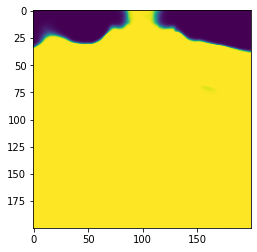

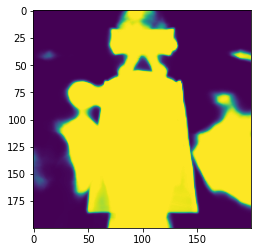

In [5]:
plt.imshow(results['opacity_coarse'].view(img_wh[1], img_wh[0]).cpu().numpy())
plt.show()
plt.imshow(results['opacity_fine'].view(img_wh[1], img_wh[0]).cpu().numpy())

In [8]:
results['static_sigmas_coarse'].view(200, 200, -1)[175, 25]

tensor([    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0008,     4.3761,
           13.1679,    20.1543,    25.6985,    27.2525,    25.6827,    22.1939,
           17.3777,    10.3997,     2.9879,     0.0374,     0.0010,     0.0001,
            0.0001,     0.0004,     0.0028,     0.0194,     0.1030,     0.1378,
            0.0696,     0.0217,     0.0033,     0.0002,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0')

In [9]:
results['static_sigmas_fine'].view(200, 200, -1)[175, 25]

tensor([    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.00

PSNR 22.887088775634766


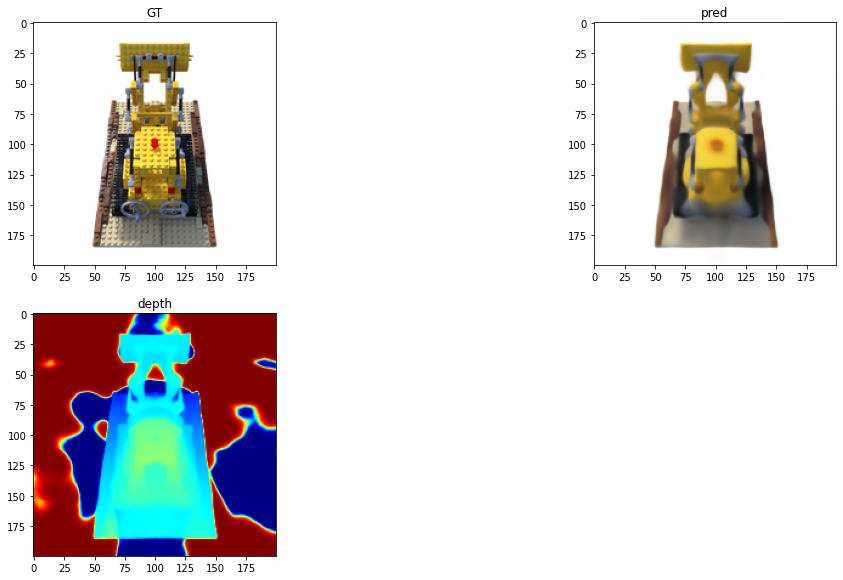

In [11]:
img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])

print('PSNR', metrics.psnr(img_gt, img_pred).item())

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(221)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(222)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(223)
plt.title('depth')
plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
plt.show()